In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Importing libraries
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt
from brokenaxes import brokenaxes
import seaborn as sns

from src.models import parameter_learning as lfi
from src.models import build_model as build
from src.models import model_schemata as schema
from src.models import inference as inf
from src.visualization import visualize as viz

In [13]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

In [14]:
log_directory = 'models/ebdt_data/sub_network/e_model/'
mle_analysis, weights = lfi.analyze_and_store_logs(log_directory)

In [15]:
mle_analysis.keys()

dict_keys(['exp1-100i', 'exp2-100i'])

In [16]:
mle_scores = {}
# keys = list(mle_analysis.keys())
keys = ['exp1-100i', 'exp2-100i']
keys.sort()
for key in keys:
    mle_scores[key] = mle_analysis[key]['MLE scores']

#### Evaluation of learning process

Compare score after N iterations

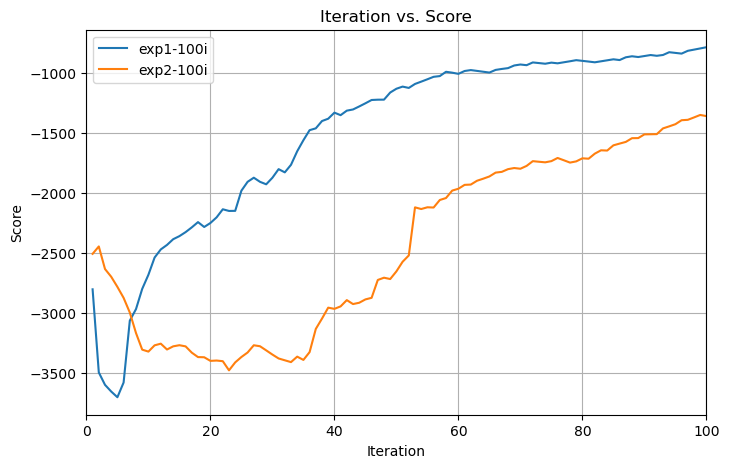

In [8]:
sns.reset_orig()
viz.plot_iteration_scores(mle_scores, xlim=(0, 100))

In [9]:
def custom_fit_plot_a(dataframes, xlim=None, ylim=None, secondary_keys=['exp4-200i', 'exp8-200i']):

    sns.set(style="whitegrid")  # Start with a white grid style

    # Save the current Seaborn settings
    current_context = sns.plotting_context()
    current_style = sns.axes_style()

    # Reset to Matplotlib defaults
    plt.rcdefaults()

    # Reapply the saved Seaborn settings except for the color palette
    sns.set_context(current_context)
    sns.set_style(current_style)

    fig, ax1 = plt.subplots(figsize=(8, 5), dpi=100)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color_map = {
        'exp4-200i': '#d62728',
        'exp8-200i': '#e377c2'  # you can change 'red' and 'blue' to any valid matplotlib color
    }

    for exp, df in dataframes.items():
        if 'Iteration' not in df.columns or 'Score' not in df.columns:
            print("Each DataFrame must contain 'Iteration' and 'Score' columns.")
            return
        
        # Select rows where iterations are within xlim
        if xlim is not None:
            df = df[(df['Iteration'] >= xlim[0]) & (df['Iteration'] <= xlim[1])]
        
        # Select rows where scores are within ylim
        if ylim is not None:
            df = df[(df['Score'] >= ylim[0]) & (df['Score'] <= ylim[1])]
        
        ax1.plot(df['Iteration'], df['Score'], marker='', linestyle='-', linewidth=1.5, label=exp.replace('-200i', ''))

        if exp in secondary_keys:
            ax2.plot(df['Iteration'], df['Score'], linestyle='--', linewidth=1.5, color = color_map.get(exp), label=exp.replace('-200i', ''))
        
            
    ax1.set_xlabel('Iteration', fontsize=14)
    ax1.set_ylabel('Log-likelihood', fontsize=14)
    ax2.set_ylabel('')  # we already handled the x-label with ax1

    # Increase the legibility of the ticks
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    if ylim is not None:
        ax1.set_ylim(ylim)
    
    # Set axis limits if provided
    if xlim is not None:
        ax1.set_xlim(xlim)
    
    # Improve the grid, make it lighter
    ax1.grid(True, linestyle='--', linewidth=0.5)
    ax2.grid(False)
    
    ax1.legend(loc='lower right', fontsize=12)  # Add legends for each DataFrame
    ax2.legend(loc='upper right', fontsize=12)  # Add legends for each DataFrame

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


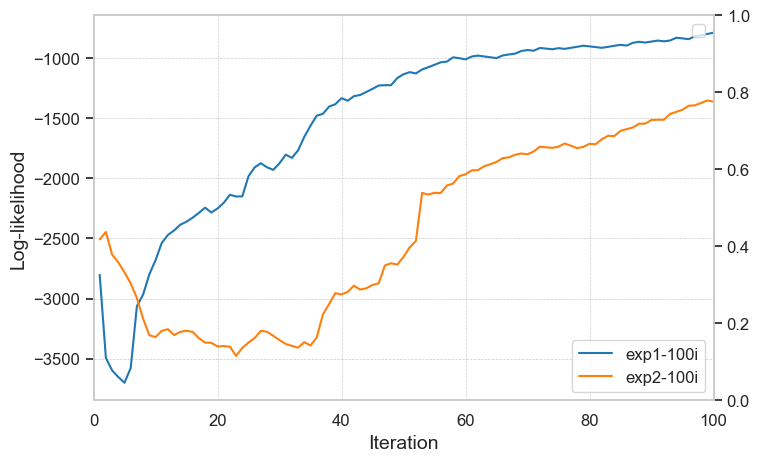

In [10]:
custom_fit_plot_a(mle_scores, xlim=(0, 100))

Compare time per iteration

In [11]:
keys = ['exp1-100i', 'exp2-100i']
times_per_it = {}
compile_time = {}
for key in keys:
    # Remove -200i and -40i from the x-labels
    times_per_it[key] = mle_analysis[key]['Time per iteration'] / 60
    compile_time[key] = mle_analysis[key]['Compile Time'] / 60
    
# Convert your data to a suitable format for Seaborn
data = []
for key, time, compile_t in zip(keys, times_per_it.values(), compile_time.values()):
    data.append({'run': key.split('-')[0], 'times_per_it': time, 'compile_time': compile_t})

df = pd.DataFrame(data)

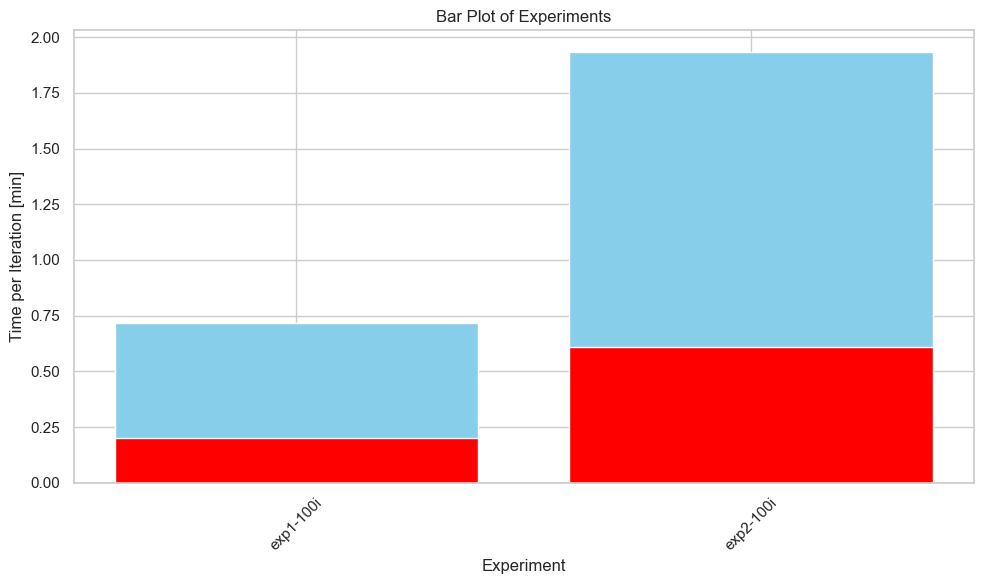

In [12]:
# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(list(times_per_it.keys()), list(times_per_it.values()), color='skyblue')
plt.bar(list(compile_time.keys()), list(compile_time.values()), color='red')

plt.xlabel('Experiment')
plt.ylabel('Time per Iteration [min]')
plt.title('Bar Plot of Experiments')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()  # Ensure the labels fit within the figure boundaries

# Display the plot
plt.show()

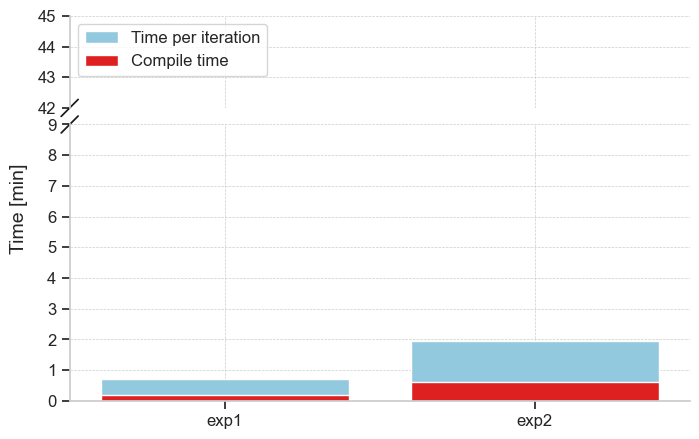

In [13]:
sns.reset_orig()
sns.set(style="whitegrid")

fig = plt.figure(figsize=(8, 5), dpi=100)
bax = brokenaxes(ylims=((0, 9), (42, 45)), hspace=0.09)

# Create bar plots using Seaborn on each broken axis
for ax in bax.axs:
    sns.barplot(x='run', y='times_per_it', data=df, color='skyblue', label='Time per iteration', ax=ax)
    sns.barplot(x='run', y='compile_time', data=df, color='red', label='Compile time', ax=ax)

# Set labels
for ax in bax.axs:
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.tick_params(axis='both', which='major', labelsize=12)
bax.set_ylabel('Time [min]', fontsize=14)

# Add and position the legend
handles, labels = bax.axs[0].get_legend_handles_labels()
plt.legend(handles, labels, loc='upper left', fontsize='12')

# Improve the grid and despine for each subplot
for ax in bax.axs:
    ax.grid(True, linestyle='--', linewidth=0.5)
    # sns.despine(ax=ax, trim=False, left=True)

plt.show()


Compare maximum difference between consecutive iterations

In [17]:
# for every pair of consecutive iterations i i+1, I want to calculate the absolute difference between each of the weights, 
# then calculate the sum, the average and standard deviation of these differences and store them in a new dataframe
# then I want to plot the average difference for each iteration
max_diff = {}
# keys = list(weights.keys())
# keys.sort()
for key in keys:
    new_key = key.replace('-200i', '').replace('-40i', '')
    max_diff[new_key] = weights[key]['differences_df']

In [18]:
def custom_fit_plot_cd(dataframes, metric='Average Difference', xlim=None, ylim=None, title=None):
    
    sns.set(style="whitegrid")  # Start with a white grid style

    # Save the current Seaborn settings
    current_context = sns.plotting_context()
    current_style = sns.axes_style()

    # Reset to Matplotlib defaults
    plt.rcdefaults()

    # Reapply the saved Seaborn settings except for the color palette
    sns.set_context(current_context)
    sns.set_style(current_style)
    
    plt.figure(figsize=(8, 5), dpi=100)

    for exp, df in dataframes.items():
        
        # Select rows where iterations and metric values are within the specified limits
        if xlim is not None:
            df = df[(df['Iteration'] >= xlim[0]) & (df['Iteration'] <= xlim[1])]
        if ylim is not None:
            df = df[(df[metric] >= ylim[0]) & (df[metric] <= ylim[1])]

        sns.lineplot(x='Iteration', y=metric, data=df, label=exp, linewidth=1.5)

    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel(f'Parameters - {metric}', fontsize=14)

    # Set axis limits if provided
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # Improve the grid, make it lighter
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Increase the legibility of the ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Set x-axis to display only integer ticks
    #plt.xticks(range(2, 101, 2))

    plt.legend(title=None, fontsize='12')

    plt.show()

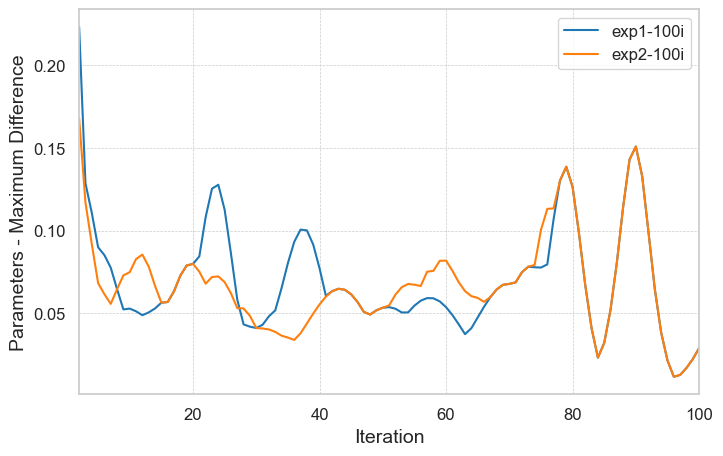

In [16]:
custom_fit_plot_cd(max_diff, metric='Maximum Difference', xlim=(2, 100))

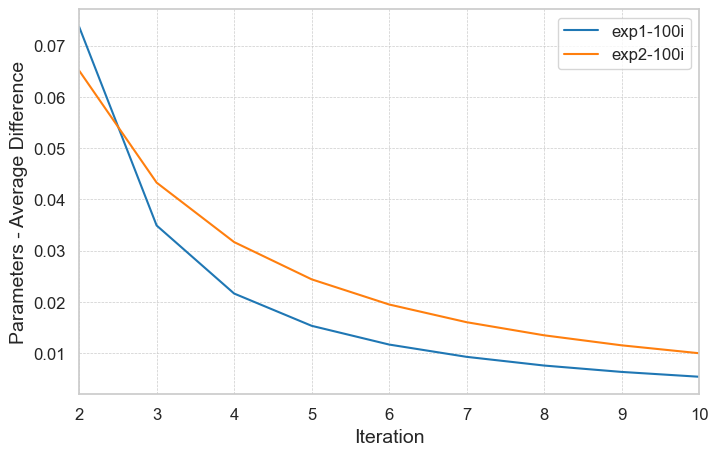

In [17]:
custom_fit_plot_cd(max_diff, metric='Average Difference', xlim=(2, 10))

#### Evaluation of learned parameters

In [19]:
experiments = ['exp1_100i', 'exp2_100i']
predicates = ['e_activity', 'act_dec', 'act_inc', 'p_occupancy', 'p_regulates']

In [20]:
result_dict = {}
for exp in experiments:
    # Example usage: Replace 'your_file_path.txt' with the actual file path
    file_path = f'models/ebdt_data/sub_network/e_model/e_model_{exp}.pl'
    result_dict[exp] = lfi.extract_params_from_model_file(file_path)
    #remove duplicates, keep last occurence
    for predicate, data in result_dict[exp].items():
        result_dict[exp][predicate] = lfi.learned_parameters_to_df(predicate, data).reset_index(drop=True)

Average JSD per experiment pair
* calculate jsd for every pair where overlap. then calculate average to for similarity (matrix of experiments)
* calculate average jsd for individual predicates e.g. occupancy

In [20]:
predicates = ['e_activity', 'act_dec', 'act_inc', 'p_occupancy', 'p_function']

jsd_dict = {}

# Iterate over predicates
for pred in predicates:
    jsd_dict[pred] = lfi.compare_jsds(pred, experiments, result_dict)

In [21]:
predicates = ['e_activity', 'act_dec', 'act_inc', 'p_occupancy', 'p_function']
average_jsd_matrix = viz.calc_average_jsd_heatmap(experiments, predicates, jsd_dict)

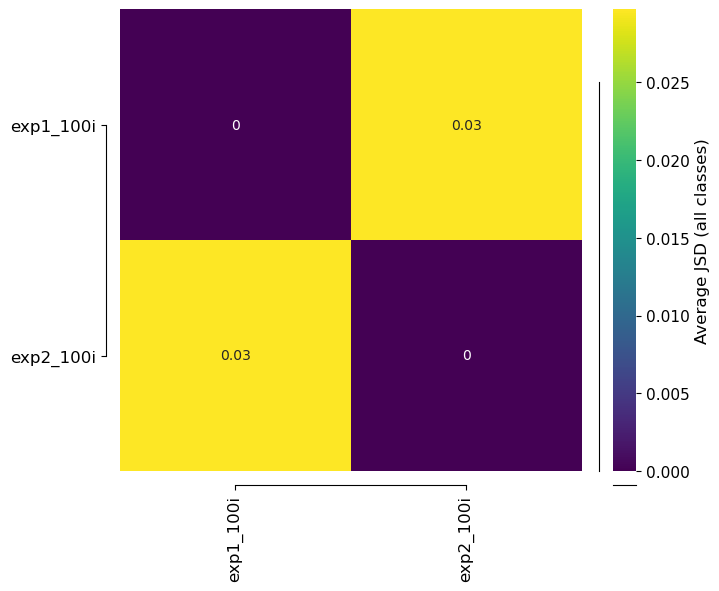

In [22]:
# Assuming average_jsd_matrix is your JSD matrix
sns.reset_orig()
viz.plot_clustered_heatmap(average_jsd_matrix)

In [23]:
p_occupancy_jsd_matrix = viz.calc_individual_predicate_jsd_heatmap(experiments, 'p_occupancy', jsd_dict)

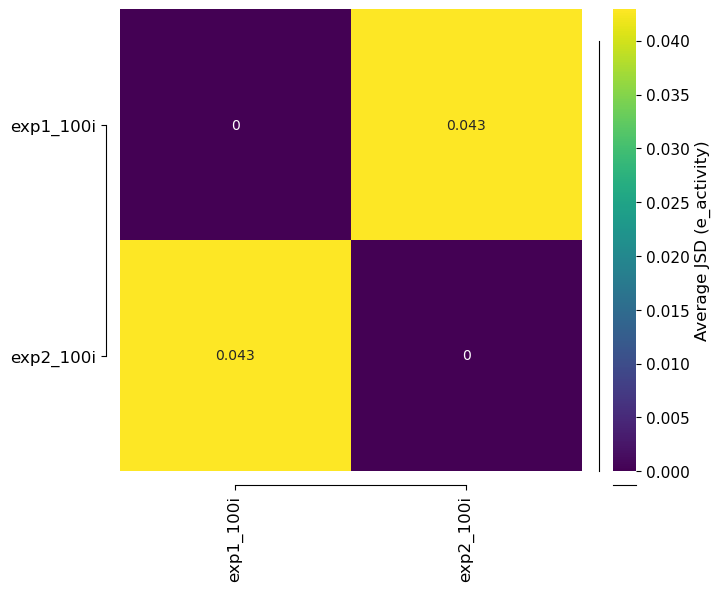

In [24]:
# Assuming average_jsd_matrix is your JSD matrix
sns.reset_orig()
viz.plot_clustered_heatmap(p_occupancy_jsd_matrix, score_type='Average JSD (e_activity)')

Average fraction of MaxMatch per experiment pair

In [25]:
experiments = ['exp1_100i', 'exp2_100i']
predicates = ['e_activity', 'act_dec', 'act_inc', 'p_occupancy', 'p_function']

max_dict = {}

# Iterate over predicates
for pred in predicates:
    max_dict[pred] = lfi.compare_max_categories(pred, experiments, result_dict)

In [26]:
predicates = ['e_activity', 'act_dec', 'act_inc', 'p_occupancy', 'p_function']
average_overlap_matrix = viz.calc_average_overlap_heatmap(experiments, predicates, max_dict)

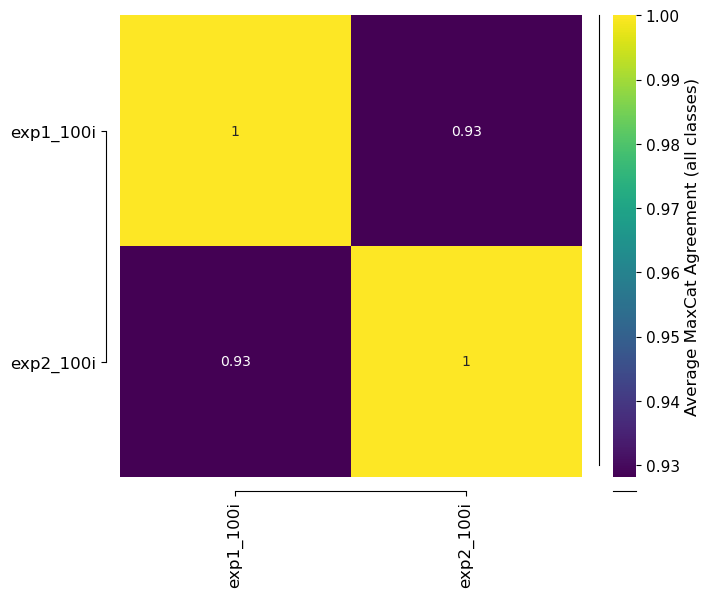

In [27]:
# Assuming average_jsd_matrix is your JSD matrix
sns.reset_orig()
viz.plot_clustered_heatmap(average_overlap_matrix, score_type='Average MaxCat Agreement (all classes)')

In [28]:
p_occupancy_overlap_matrix = viz.calc_individual_predicate_overlap_heatmap(experiments, 'p_occupancy', max_dict)

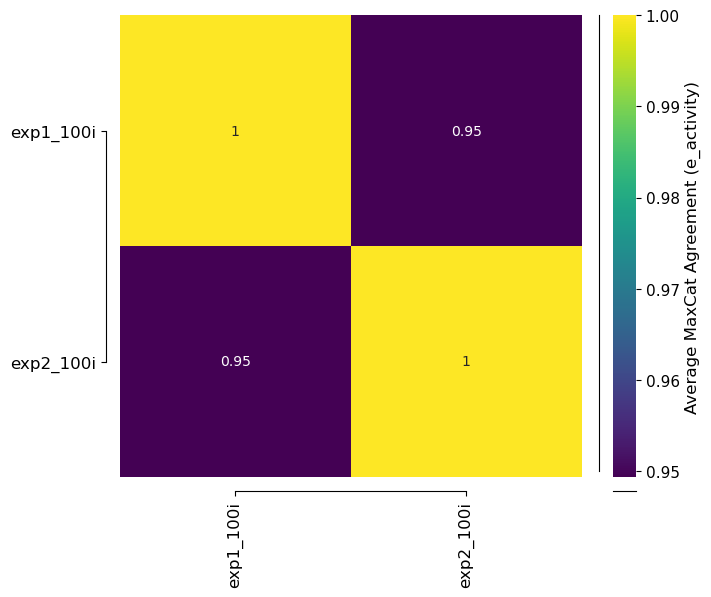

In [29]:
# Assuming average_jsd_matrix is your JSD matrix
sns.reset_orig()
viz.plot_clustered_heatmap(p_occupancy_overlap_matrix, score_type='Average MaxCat Agreement (e_activity)')

#### Compare AUC (all experiments)

In [21]:
p_fc = pd.read_csv('data/processed/ebdt_data/sub_network_e/p_fc.csv')

In [22]:
p_fc['p_base'] = 1 - p_fc['p_dec'] - p_fc['p_inc']
p_fc.loc[p_fc['p_base'] < 0, 'p_base'] = 0


In [23]:
p_fc

,phosphosite,sample,value,prob,p_dec,p_inc,p_base
0,ABL1(S569),AZD5438,inc,0.657336,0.00100,0.657336,0.341664
1,ABL1(S718),AZD5438,inc,0.422202,0.00100,0.422202,0.576798
2,ABL1(T735),AZD5438,inc,0.998006,0.00100,0.998006,0.000994
3,HIPK2(Y361),AZD5438,dec,0.458100,0.45810,0.001000,0.540900
4,PTK2(S29),AZD5438,dec,0.451380,0.45138,0.001000,0.547620
...,...,...,...,...,...,...,...
666,PTK2(S843),Torin,inc,0.997989,0.00100,0.997989,0.001011
667,PTK2(S843),Trametinib,inc,0.998004,0.00100,0.998004,0.000996
668,PTK2(S843),U73122,dec,0.001000,0.00100,0.001000,0.998000
669,PTK2(S843),Ulixertinib,dec,0.001000,0.00100,0.001000,0.998000


In [24]:
result_dict['exp1_100i']['p_occupancy']

value,phosphosite,sample,line,p_dec,p_inc,p_base
0,ABL1(S569),AC220,"p::p_occupancy(""ABL1(S569)"",""AC220"",dec); p::p...",0.0,1.0,0.0
1,ABL1(S569),AT13148,"p::p_occupancy(""ABL1(S569)"",""AT13148"",dec); p:...",0.0,1.0,0.0
2,ABL1(S569),AZ20,"p::p_occupancy(""ABL1(S569)"",""AZ20"",dec); p::p_...",0.0,1.0,0.0
3,ABL1(S569),AZD1480,"p::p_occupancy(""ABL1(S569)"",""AZD1480"",dec); p:...",0.0,1.0,0.0
4,ABL1(S569),AZD3759,"p::p_occupancy(""ABL1(S569)"",""AZD3759"",dec); p:...",1.0,0.0,0.0
...,...,...,...,...,...,...
666,SRC(S75),Torin,"p::p_occupancy(""SRC(S75)"",""Torin"",dec); p::p_o...",1.0,0.0,0.0
667,SRC(S75),Trametinib,"p::p_occupancy(""SRC(S75)"",""Trametinib"",dec); p...",0.0,1.0,0.0
668,SRC(S75),U73122,"p::p_occupancy(""SRC(S75)"",""U73122"",dec); p::p_...",0.0,1.0,0.0
669,SRC(S75),Ulixertinib,"p::p_occupancy(""SRC(S75)"",""Ulixertinib"",dec); ...",1.0,0.0,0.0


In [25]:
analysis_dicts_0 = inf.prep_experiments_for_auc(result_dict, p_fc, result_type='p_occupancy', y_true_type='p_fc', threshold=0)

AUC Plots

In [26]:
y_onehot_test_list_0 = []
y_score_list_0 = []
experiment_names = []
for exp in analysis_dicts_0.keys():
    y_onehot_test_list_0.append(analysis_dicts_0[exp]['y_onehot_test'])
    y_score_list_0.append(analysis_dicts_0[exp]['y_score'])
    experiment_names.append(exp)

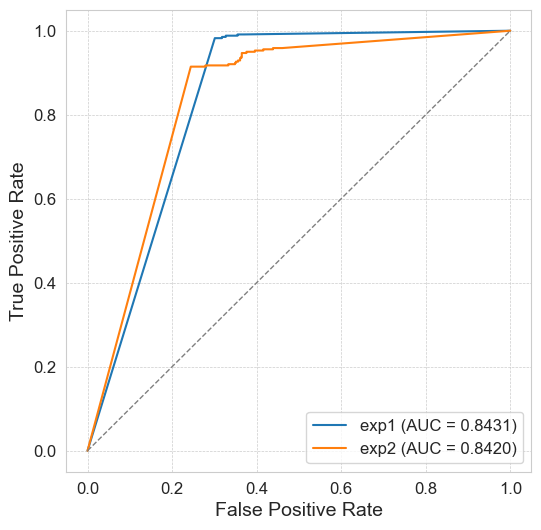

In [27]:
auc_df = viz.plot_micro_average_roc_seaborn(y_onehot_test_list_0, y_score_list_0, experiment_names)

In [28]:
analysis_dicts_80 = inf.prep_experiments_for_auc(result_dict, p_fc, result_type='p_occupancy', y_true_type='p_fc', threshold=0.8)
y_onehot_test_list_80 = []
y_score_list_80 = []
experiment_names = []
for exp in analysis_dicts_80.keys():
    y_onehot_test_list_80.append(analysis_dicts_80[exp]['y_onehot_test'])
    y_score_list_80.append(analysis_dicts_80[exp]['y_score'])
    experiment_names.append(exp)

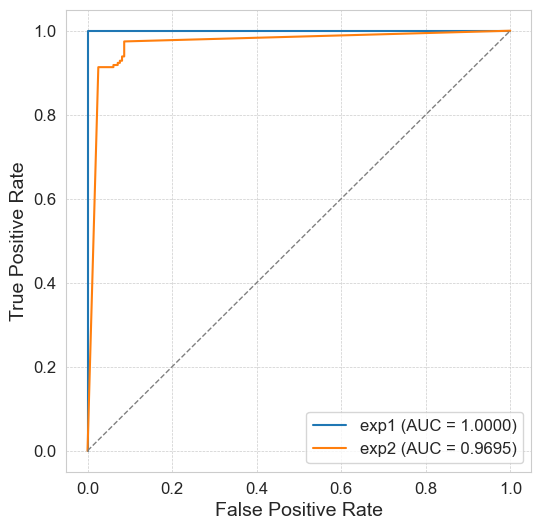

In [29]:
auc_df = viz.plot_micro_average_roc_seaborn(y_onehot_test_list_80, y_score_list_80, experiment_names)

#### Evaluation learned parameters: exp5 (ksea) vs exp10 (ksea pen)

In [30]:
# Extracting data from your analysis dictionary
x = analysis_dicts_0['exp1_100i']['analysis_dataframe']['prob']
y = analysis_dicts_0['exp1_100i']['analysis_dataframe']['JSD']
mask_no_match = analysis_dicts_0['exp1_100i']['analysis_dataframe']['MaxMatch'] == 0

In [31]:
# Extracting data from your analysis dictionary
x = analysis_dicts_0['exp2_100i']['analysis_dataframe']['prob']
y = analysis_dicts_0['exp2_100i']['analysis_dataframe']['JSD']
mask_no_match = analysis_dicts_0['exp2_100i']['analysis_dataframe']['MaxMatch'] == 0

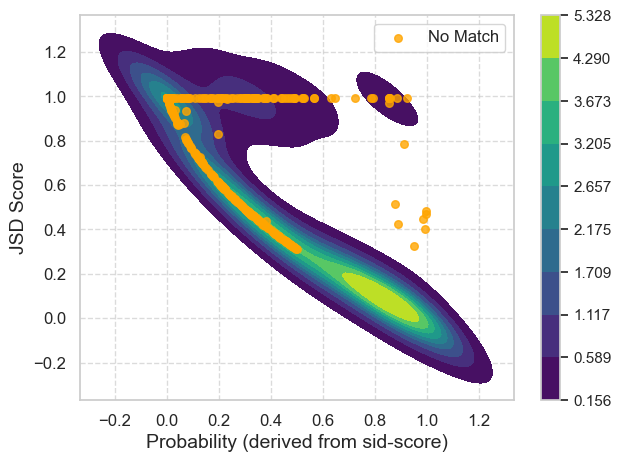

In [41]:
sns.set(style="whitegrid")  # Start with a white grid style

plt.figure(figsize=(7, 5), dpi=100)

# Create the kdeplot
sns.kdeplot(x=x, y=y, cmap='viridis', fill=True, levels=10, cbar=True)

# Scatter plot for 'MaxMatch' == 0 (Non Matches)
plt.scatter(x[mask_no_match], y[mask_no_match], c='orange', s=30, alpha=0.8, label='No Match')

# Increase the legibility of the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding labels, title, and legend
plt.xlabel('Probability (derived from sid-score)', fontsize=14)
plt.ylabel('JSD Score', fontsize=14)
plt.legend(loc='upper right', fontsize=12)

# Enhance readability
plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()  # Adjusts the plot to ensure everything fits well

# Display the plot
plt.show()

In [32]:
# Data extraction
data1 = analysis_dicts_0['exp1_100i']['analysis_dataframe']['JSD']
data2 = analysis_dicts_0['exp2_100i']['analysis_dataframe']['JSD']

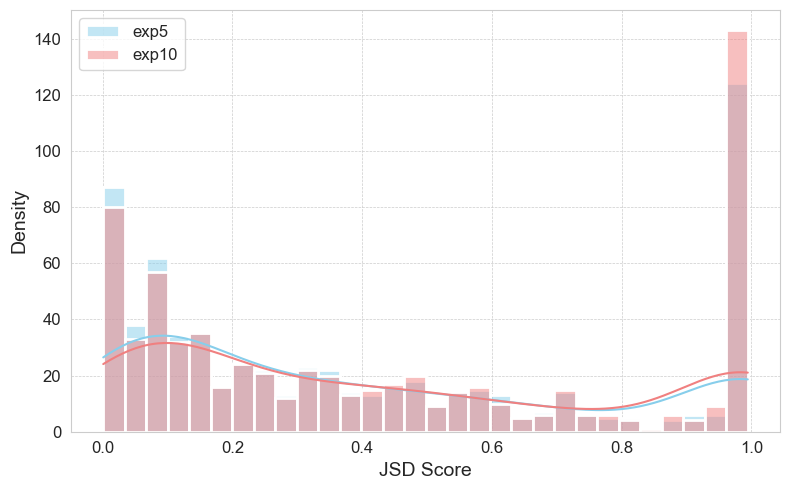

In [33]:
# Set a theme for seaborn for a nicer look
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(8, 5))

# Plot the KDE for data1
sns.histplot(data1, bins=30, kde=True, color='skyblue', linewidth=2, label='exp5')

# Plot the KDE for data2
sns.histplot(data2, bins=30, kde=True, color='lightcoral', linewidth=2, label='exp10')  # Change color and label as appropriate

# Add titles, labels, and legend
plt.xlabel('JSD Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.grid(True, linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

#### Evaluation pf learned interactions

In [34]:
result_dict['exp1_100i']['p_function']
res1 = result_dict['exp1_100i']['p_function'][['phosphosite', 'function', 'probability']]

In [35]:
res1

,phosphosite,function,probability
0,ABL1(S718),p_dec,0.351277
1,ABL1(S718),p_inc,0.648723
2,PTK2(S29),p_dec,0.467978
3,PTK2(S29),p_inc,0.532022
4,PTK2(S722),p_dec,0.371595
5,PTK2(S722),p_inc,0.628405
6,PTPRG(S995),p_dec,0.005922
7,PTPRG(S995),p_inc,0.994078


In [36]:
result_dict['exp2_100i']['p_function']
res2 = result_dict['exp2_100i']['p_function'][['phosphosite', 'function', 'probability']]
res2

,phosphosite,function,probability
0,ABL1(S718),p_dec,0.392951
1,ABL1(S718),p_inc,0.607049
2,PTK2(S29),p_dec,0.507563
3,PTK2(S29),p_inc,0.492437
4,PTK2(S722),p_dec,0.379900
5,PTK2(S722),p_inc,0.620100
6,PTPRG(S995),p_dec,0.005922
7,PTPRG(S995),p_inc,0.994078


In [37]:
# Separate the data into two datasets for the different functions
p_inc_data = res2[res2['function'] == 'p_inc']
p_dec_data = res2[res2['function'] == 'p_dec']

# Invert the probabilities for p_dec to display them on the left
p_dec_data['probability'] *= -1

# Concatenate the data back for plotting
plot_data = pd.concat([p_dec_data, p_inc_data])

/var/folders/l3/vxqxpwf10_x9jp7g4_x9yy9m0000gn/T/ipykernel_8248/279925997.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_dec_data['probability'] *= -1


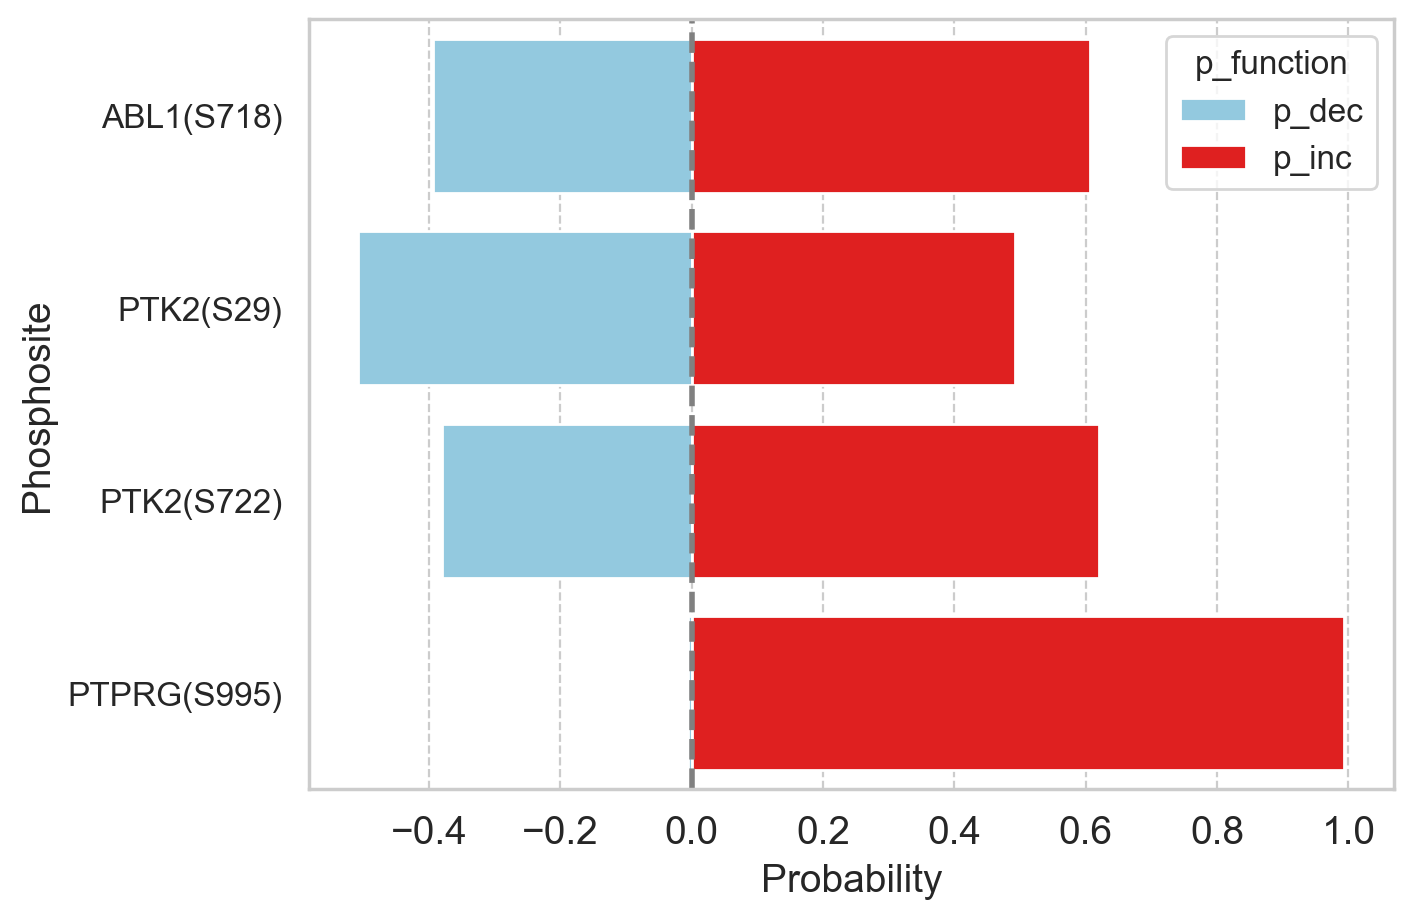

In [38]:
sns.set(style="whitegrid")  # Start with a white grid style
# Create the barplot with specified colors
plt.figure(figsize=(7, 5), dpi=200)
barplot = sns.barplot(x='probability', y='phosphosite', data=plot_data, hue='function',
                      dodge=False, palette={'p_inc': 'red', 'p_dec': 'skyblue'})

# Adjust the legend
plt.legend(title='p_function', loc='upper right', fontsize=12)

plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=12)

# Set labels
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Phosphosite', fontsize=14)

# Draw a vertical line at x=0
plt.axvline(x=0, color='grey', linewidth=2, alpha=1, linestyle='--')
plt.grid(True, axis='x', linestyle='--', linewidth=0.8)

# Show the plot
plt.show()